<center>
<h4>Diplomatura en CDAAyA 2019 - FaMAF - UNC</h4>
<h1>¿Caro o Barato? Análisis de Precios de Almacen en un Contexto Inflacionario</h1>
<h3>Preprocesamiento</h3>
</center>
</left>
<h4>Sofía Luján y Julieta Bergamasco</h4>
</left>

__[Proyecto para Mentoría](https://sites.google.com/view/mentorias2020-diplodatos/caro-o-barato-an%C3%A1lisis-de-precios-de-almac%C3%A9n-en-un-contexto-inflacionari?authuser=0)__


# Descripción del Dataset y Objetivo

El dataset consiste en extracciones periódicas semanales de la página de Precios Claros (http://preciosclaros.gob.ar/), que contienen la lista de precios de un día de la semana para una serie de productos y proveedores seleccionados. Al momento de la elaboración de este proyecto ya hay cinco extracciones generadas, para las siguientes fechas: 12/04/20, 19/04/20, 26/04/20, 05/05/2020 y 18/05/2020.

Estos datos fueron obtenidos a partir de un scrapper (open source) disponibilizado por Open Data Córdoba (https://www.opendatacordoba.org/) y los csv fueron puestos a disposición en Kaggle (https://www.kaggle.com/tinnqn/precios-claros-precios-de-argentina).

Además, proveedores y productos están identificados con una foreing key relacionada con una entidad específica para cada uno de ellos: productos.csv y sucursales.csv, respectivamente. Dentro de sucursales.csv se encuentra la descripción del proveedor, provincia, localidad, latitud, longitud y tipo, entre otos datos.

Por otro lado, dentro de productos.csv se encuentra la descripción de los productos, así como también su formato (presentación), un dato clave al momento de comparar precios. Adicionalmente, existen columnas para identificar la categoría de cada producto. Sin embargo, para la mayoría de ellos, lamentablemente, es un dato faltante.

El **objetivo final de este proyecto** es encontrar una forma de identificar si un producto está caro o barato, no en una sucursal puntual, sino dada una región o ciudad.

## Importaciones y Lectura de Datos

In [80]:
import pandas as pd
from io import StringIO
import plotly.express as px
import re
import numpy as np
import seaborn as sns

In [81]:
precios_20200412_20200413 = pd.read_csv('https://raw.githubusercontent.com/solujan/mentoria_2020/master/raw_dataset/precios_20200412_20200413.csv')
precios_20200419_20200419 = pd.read_csv('https://raw.githubusercontent.com/solujan/mentoria_2020/master/raw_dataset/precios_20200419_20200419.csv')
precios_20200426_20200426 = pd.read_csv('https://raw.githubusercontent.com/solujan/mentoria_2020/master/raw_dataset/precios_20200426_20200426.csv')
precios_20200502_20200503 = pd.read_csv('https://raw.githubusercontent.com/solujan/mentoria_2020/master/raw_dataset/precios_20200502_20200503.csv')
precios_20200518_20200518 = pd.read_csv('https://raw.githubusercontent.com/solujan/mentoria_2020/master/raw_dataset/precios_20200518_20200518.csv')
productos = pd.read_csv('https://raw.githubusercontent.com/solujan/mentoria_2020/master/raw_dataset/productos.csv')
sucursales = pd.read_csv('https://raw.githubusercontent.com/solujan/mentoria_2020/master/raw_dataset/sucursales.csv')


## Descripción de Features

### Dataset Precios (incluye los 5 archivos):
*   precio: Precio del producto en pesos argentinos
*   producto_id: Código EAN del producto
*   sucursal_id: ID de la sucursal. Los dos primeros numeros determinan la cadena.

In [82]:
precios_20200412_20200413.head()

,precio,producto_id,sucursal_id
0,29.90,0000000001663,2-1-014
1,29.90,0000000002288,2-1-032
2,39.90,0000000002288,2-1-096
3,499.99,0000000205870,9-1-686
4,519.99,0000000205870,9-2-248


### Dataset Sucursales
* ID: Es el ID principal, compuesto por la concatenacion de banderaId-comercioId-sucursalId.
* comercioId: es el identificador de la empresa controlante. Por ejemplo Hipermecado Carrefour y Express tienen mismo comercioId pero distinta banderaId
* banderaId: Diferencia las distintas "cadenas" de la misma empresa. Vea, Disco y jumbo pertenecen al mismo comercio pero tienen distinta bandera.
* banderaDescripcion: Nombre de fantansia de la Cadena
* comercioRazonSocial
* provincia (con código ISO 3166-2:AR)
* localidad
* direccion
* lat
* lng



In [83]:
sucursales.head()

,id,comercioId,banderaId,banderaDescripcion,comercioRazonSocial,provincia,localidad,direccion,lat,lng,sucursalNombre,sucursalTipo
0,1-1-7,1,1,Super MAMI,Dinosaurio S.A.,AR-X,SALSIPUEDES,E53 1011 None,-31.126667,-64.295250,Super Mami 4,Hipermercado
1,10-1-1,10,1,Hipermercado Carrefour,INC S.A.,AR-B,San Isidro,Bernardo De Irigoyen 2647,-34.491345,-58.589025,San Isidro,Hipermercado
2,10-1-10,10,1,Hipermercado Carrefour,INC S.A.,AR-B,Hurlingham,Av. Vergara 1910,-34.620610,-58.633769,Villa Tesei,Hipermercado
3,10-1-11,10,1,Hipermercado Carrefour,INC S.A.,AR-B,Malvinas Argentinas,Av. Arturo Illia 3770,-34.528883,-58.701631,Malvinas Argentinas,Hipermercado
4,10-1-112,10,1,Hipermercado Carrefour,INC S.A.,AR-A,Salta,20 De Febrero 37,-24.789072,-65.413699,Salta,Hipermercado


Para obtener los nombres y regiones de las provincias de acuerdo a sus códigos, vamos a utilizar la información que se encuentra en https://es.wikipedia.org/wiki/ISO_3166-2:AR y de https://es.wikipedia.org/wiki/Regiones_integradas_(Argentina)

In [84]:
provincia_txt = """
provincia	nom_provincia	region
AR-A	Salta	Norte Grande
AR-B	Provincia de Buenos Aires	Centro
AR-C	Ciudad Autónoma de Buenos Aires	Centro
AR-D	San Luis	Cuyo
AR-E	Entre Ríos	Centro
AR-F	La Rioja	Cuyo
AR-G	Santiago del Estero	Norte Grande
AR-H	Chaco	Norte Grande
AR-J	San Juan	Cuyo
AR-K	Catamarca	Norte Grande
AR-L	La Pampa	Centro
AR-M	Mendoza	Cuyo
AR-N	Misiones	Norte Grande
AR-P	Formosa	Norte Grande
AR-Q	Neuquén	Patagonia
AR-R	Río Negro	Patagonia
AR-S	Santa Fe	Centro
AR-T	Tucumán	Norte Grande
AR-U	Chubut	Patagonia
AR-V	Tierra del Fuego	Patagonia
AR-W	Corrientes	Norte Grande
AR-X	Córdoba	Centro
AR-Y	Jujuy	Norte Grande
AR-Z	Santa Cruz	Patagonia
"""
provincia_csv = StringIO(provincia_txt)
entidad_provincia = pd.read_csv(provincia_csv, sep=('\t'))
entidad_provincia

,provincia,nom_provincia,region
0,AR-A,Salta,Norte Grande
1,AR-B,Provincia de Buenos Aires,Centro
2,AR-C,Ciudad Autónoma de Buenos Aires,Centro
3,AR-D,San Luis,Cuyo
4,AR-E,Entre Ríos,Centro
5,AR-F,La Rioja,Cuyo
6,AR-G,Santiago del Estero,Norte Grande
7,AR-H,Chaco,Norte Grande
8,AR-J,San Juan,Cuyo
9,AR-K,Catamarca,Norte Grande


In [85]:
sucursales = sucursales.merge(entidad_provincia, on = 'provincia')

Exploremos un poco este dataframe.

In [86]:
sucursales.head()

,id,comercioId,banderaId,banderaDescripcion,comercioRazonSocial,provincia,localidad,direccion,lat,lng,sucursalNombre,sucursalTipo,nom_provincia,region
0,1-1-7,1,1,Super MAMI,Dinosaurio S.A.,AR-X,SALSIPUEDES,E53 1011 None,-31.126667,-64.295250,Super Mami 4,Hipermercado,Córdoba,Centro
1,10-1-24,10,1,Hipermercado Carrefour,INC S.A.,AR-X,Jardin Espinoza,Av. O'Higgins 3765,-31.455534,-64.166095,Córdoba Jardín,Hipermercado,Córdoba,Centro
2,10-1-50,10,1,Hipermercado Carrefour,INC S.A.,AR-X,Quintas de Arguello,Recta Martinolli 7850,-31.346646,-64.269297,Córdoba Recta Martinolli,Hipermercado,Córdoba,Centro
3,10-1-54,10,1,Hipermercado Carrefour,INC S.A.,AR-X,Villa Allende Lomas,Av. Río De Janeiro 1787,-31.300019,-64.276462,Córdoba Villa Allende,Hipermercado,Córdoba,Centro
4,10-1-9,10,1,Hipermercado Carrefour,INC S.A.,AR-X,Villa Urquiza,Av. Colón 4880,-31.393915,-64.242835,Córdoba Colon,Hipermercado,Córdoba,Centro


In [87]:
sucursales.shape

(2333, 14)

Veamos cómo se distribuyen geográficamente las sucursales listadas.

In [88]:
fig = px.scatter_mapbox(sucursales.drop_duplicates(['lat', 'lng']), lat="lat", lon="lng", hover_name="banderaDescripcion", hover_data=["sucursalNombre","sucursalTipo", 'comercioRazonSocial',"localidad","nom_provincia"],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

En principio, vemos que tenemos sucursales distribuidas por todo el país.

### Dataset Productos
* id
* marca
* nombre
* presentación
* categoria1
* categoria2
* categoria3

In [89]:
productos.head(20)

,id,marca,nombre,presentacion,categoria1,categoria2,categoria3
0,0000000001663,LA ANÓNIMA,Radicheta Atada La Anonima 1 Un,1.0 un,NaN,NaN,NaN
1,0000000002288,LA ANÓNIMA,Perejil Atado La Anonima 1 Un,1.0 un,NaN,NaN,NaN
2,0000000205870,SIN MARCA,Ojo de Bife 1 Kg,1.0 kg,NaN,NaN,NaN
3,0000000205894,SIN MARCA,Milanesa de Peceto Novillito 1 Kg,1.0 kg,NaN,NaN,NaN
4,0000000205955,SIN MARCA,Chiquizuela Novillito 1 Kg,1.0 kg,NaN,NaN,NaN
5,0000000205979,SIN MARCA,Espinazo de Novillito 1 Kg,1.0 kg,NaN,NaN,NaN
6,0000000206020,SIN MARCA,Carnanza Comun de Novillo 1 Kg,1.0 kg,NaN,NaN,NaN
7,0000000206044,SIN MARCA,Falda Deshuesada Novillito Bandeja 1 Kg,1.0 kg,NaN,NaN,NaN
8,0000000206051,SIN MARCA,Carne Picada Comun 1 Kg,1.0 kg,NaN,NaN,NaN
9,0000000206105,SIN MARCA,Entraña de Novillito 1 Kg,1.0 kg,NaN,NaN,NaN


Veamos de cuántos productos tenemos relevamiento de precios.

In [ ]:
productos.shape

# Union de Datos para Obtener Único Dataset

A continuación, uniremos todos los dataframes de precios, agregándole la fecha y anexaremos las características de productos y sucursales.

In [90]:
lista_df_px = [precios_20200412_20200413, precios_20200419_20200419, precios_20200426_20200426,
 precios_20200502_20200503, precios_20200518_20200518]
fecha_px = ['20200412', '20200419', '20200426', '20200502', '20200518']

In [91]:
precios = pd.DataFrame()
for df, fecha in zip(lista_df_px, fecha_px):
  df['fecha'] = fecha
  precios = pd.concat([precios,df])

precios.head()

,precio,producto_id,sucursal_id,fecha
0,29.90,0000000001663,2-1-014,20200412
1,29.90,0000000002288,2-1-032,20200412
2,39.90,0000000002288,2-1-096,20200412
3,499.99,0000000205870,9-1-686,20200412
4,519.99,0000000205870,9-2-248,20200412


In [92]:
precio_producto = pd.merge(precios,productos,left_on='producto_id',right_on='id',how='left').drop(columns = 'id')
precio_sucursal_producto = pd.merge(precio_producto,sucursales,left_on='sucursal_id', right_on='id',how='left').drop(columns = 'id')
precio_sucursal_producto.head()

,precio,producto_id,sucursal_id,fecha,marca,nombre,presentacion,categoria1,categoria2,categoria3,comercioId,banderaId,banderaDescripcion,comercioRazonSocial,provincia,localidad,direccion,lat,lng,sucursalNombre,sucursalTipo,nom_provincia,region
0,29.90,0000000001663,2-1-014,20200412,LA ANÓNIMA,Radicheta Atada La Anonima 1 Un,1.0 un,NaN,NaN,NaN,2.0,1.0,La Anonima,S.A. Importadora y Exportadora de la Patagonia,AR-U,Puerto Madryn,H.Yrigoyen 76,-42.76422,-65.03623,PUERTO MADRYN,Supermercado,Chubut,Patagonia
1,29.90,0000000002288,2-1-032,20200412,LA ANÓNIMA,Perejil Atado La Anonima 1 Un,1.0 un,NaN,NaN,NaN,2.0,1.0,La Anonima,S.A. Importadora y Exportadora de la Patagonia,AR-Z,Caleta Olivia,Belgrano 515,-46.44466,-67.52854,CALETA OLIVIA 2,Supermercado,Santa Cruz,Patagonia
2,39.90,0000000002288,2-1-096,20200412,LA ANÓNIMA,Perejil Atado La Anonima 1 Un,1.0 un,NaN,NaN,NaN,2.0,1.0,La Anonima,S.A. Importadora y Exportadora de la Patagonia,AR-B,Salto,Moreno 360,-34.29066,-60.25439,SALTO,Supermercado,Provincia de Buenos Aires,Centro
3,499.99,0000000205870,9-1-686,20200412,SIN MARCA,Ojo de Bife 1 Kg,1.0 kg,NaN,NaN,NaN,9.0,1.0,Vea,Jumbo Retail Argentina S.A.,AR-E,GUALEGUAYCHU,San Martín Entre Parana Y Gualeguay 0,-33.01060,-58.52790,Gualeguaychú,Supermercado,Entre Ríos,Centro
4,519.99,0000000205870,9-2-248,20200412,SIN MARCA,Ojo de Bife 1 Kg,1.0 kg,NaN,NaN,NaN,9.0,2.0,Disco,Jumbo Retail Argentina S.A.,AR-B,SAN BERNARDO DEL TUYU,Santiago Del Estero 2690,-36.68820,-56.68350,San Bernardo.,Supermercado,Provincia de Buenos Aires,Centro


Veamos cómo quedó compuesto nuestro dataset:

In [93]:
precio_sucursal_producto.shape

(2222418, 23)

## Tipos de Datos

Vamos a inspeccionar un poco los tipos de datos que tenemos en el dataframe.

In [94]:
data_types = precio_sucursal_producto.dtypes
data_types = pd.DataFrame(data_types)
data_types = data_types.rename(columns = {0:'ReadingDataType'})
data_types.index.names = ['FieldName']
data_types

,ReadingDataType
FieldName,
precio,float64
producto_id,object
sucursal_id,object
fecha,object
marca,object
nombre,object
presentacion,object
categoria1,object
categoria2,object


Una característica importante de nuestro dataset es que la mayoría de los datos son de tipo categóricos.

In [95]:
precio_sucursal_producto.describe(include='all')

,precio,producto_id,sucursal_id,fecha,marca,nombre,presentacion,categoria1,categoria2,categoria3,comercioId,banderaId,banderaDescripcion,comercioRazonSocial,provincia,localidad,direccion,lat,lng,sucursalNombre,sucursalTipo,nom_provincia,region
count,2.214795e+06,2222418,2222418,2222418,2222411,2222411,2222411,5,5,5,2.202418e+06,2.202418e+06,2202418,2202418,2202418,2202418,2202418,2.202418e+06,2.202418e+06,2202418,2202418,2202418,2202418
unique,NaN,71723,513,5,5644,63660,1168,2,2,2,NaN,NaN,45,34,24,309,491,NaN,NaN,464,4,24,4
top,NaN,7793100111563,49-1-2,20200426,SIN MARCA,Edulcorante Liquido Hileret Zucra 200 Cc,1.0 kg,Perfumería y Cuidado Personal,Cuidado Capilar,Acondicionadores,NaN,NaN,Hipermercado Carrefour,INC S.A.,AR-B,LA PLATA,Av. 25 De Mayo Y Garmendia 0,NaN,NaN,Super TUTI 3,Supermercado,Provincia de Buenos Aires,Centro
freq,NaN,545,75516,478909,64702,723,109079,4,4,4,NaN,NaN,339573,556047,772902,161996,75516,NaN,NaN,75516,1098212,772902,1207685
mean,1.856890e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.652005e+01,1.605384e+00,NaN,NaN,NaN,NaN,NaN,-3.454504e+01,-6.285408e+01,NaN,NaN,NaN,NaN
std,3.627679e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.432284e+01,1.096061e+00,NaN,NaN,NaN,NaN,NaN,6.110626e+00,4.054113e+00,NaN,NaN,NaN,NaN
min,1.200000e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,NaN,-5.481010e+01,-7.221356e+01,NaN,NaN,NaN,NaN
25%,6.690000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,NaN,-3.660429e+01,-6.545231e+01,NaN,NaN,NaN,NaN
50%,1.189500e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+01,1.000000e+00,NaN,NaN,NaN,NaN,NaN,-3.459195e+01,-6.289345e+01,NaN,NaN,NaN,NaN
75%,2.140000e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.600000e+01,2.000000e+00,NaN,NaN,NaN,NaN,NaN,-3.155759e+01,-5.862642e+01,NaN,NaN,NaN,NaN


## Valores Nulos

Inspeccionemos para cada columna la cantidad de valores nulos.

In [96]:
precio_sucursal_producto.isnull().sum().to_frame().sort_values(0, ascending = False).reset_index()

,index,0
0,categoria1,2222413
1,categoria2,2222413
2,categoria3,2222413
3,banderaId,20000
4,comercioRazonSocial,20000
5,nom_provincia,20000
6,sucursalTipo,20000
7,sucursalNombre,20000
8,lng,20000
9,lat,20000


Notar que las categorías de productos no se encuentran para ninguno de los niveles.

## Exploración de Features

Vamos a explorar las diferentes unidades de medidas con las que nos vamos a encontrar.

In [97]:
presentacion = pd.Series(precio_sucursal_producto['presentacion'].unique())
um = pd.Series(presentacion.str[-2:].unique())
um

0     un
1     kg
2     gr
3     ml
4     cc
5     lt
6     mt
7    NaN
dtype: object

Además, como podemos observar, el nombre del producto contiene también la presentación del mismo.

In [98]:
nombre = pd.Series(precio_sucursal_producto['nombre'].unique())
nombre.head()

0      Radicheta Atada La Anonima 1 Un
1        Perejil Atado La Anonima 1 Un
2                     Ojo de Bife 1 Kg
3    Milanesa de Peceto Novillito 1 Kg
4           Chiquizuela Novillito 1 Kg
dtype: object

Veamos cuántos registros tenemos sin nombre de producto, y sin nombre ni presentación.

In [99]:
precio_sucursal_producto['nombre'].isna().sum()

7

In [100]:
(precio_sucursal_producto['nombre'].isna() & precio_sucursal_producto['presentacion'].isna()).sum()

7

Eliminamos estas filas por cuestiones exploratorias.

In [101]:
precio_sucursal_producto = precio_sucursal_producto.dropna(subset=['nombre'])

In [102]:
presentacion_splitted = precio_sucursal_producto["presentacion"].str.split(" ", n = 1, expand = True)
precio_sucursal_producto["cantidad"]= presentacion_splitted[0] 
precio_sucursal_producto["cantidad"] = pd.to_numeric(precio_sucursal_producto["cantidad"])  
precio_sucursal_producto["unidad"]= presentacion_splitted[1] 
precio_sucursal_producto.head()

,precio,producto_id,sucursal_id,fecha,marca,nombre,presentacion,categoria1,categoria2,categoria3,comercioId,banderaId,banderaDescripcion,comercioRazonSocial,provincia,localidad,direccion,lat,lng,sucursalNombre,sucursalTipo,nom_provincia,region,cantidad,unidad
0,29.90,0000000001663,2-1-014,20200412,LA ANÓNIMA,Radicheta Atada La Anonima 1 Un,1.0 un,NaN,NaN,NaN,2.0,1.0,La Anonima,S.A. Importadora y Exportadora de la Patagonia,AR-U,Puerto Madryn,H.Yrigoyen 76,-42.76422,-65.03623,PUERTO MADRYN,Supermercado,Chubut,Patagonia,1.0,un
1,29.90,0000000002288,2-1-032,20200412,LA ANÓNIMA,Perejil Atado La Anonima 1 Un,1.0 un,NaN,NaN,NaN,2.0,1.0,La Anonima,S.A. Importadora y Exportadora de la Patagonia,AR-Z,Caleta Olivia,Belgrano 515,-46.44466,-67.52854,CALETA OLIVIA 2,Supermercado,Santa Cruz,Patagonia,1.0,un
2,39.90,0000000002288,2-1-096,20200412,LA ANÓNIMA,Perejil Atado La Anonima 1 Un,1.0 un,NaN,NaN,NaN,2.0,1.0,La Anonima,S.A. Importadora y Exportadora de la Patagonia,AR-B,Salto,Moreno 360,-34.29066,-60.25439,SALTO,Supermercado,Provincia de Buenos Aires,Centro,1.0,un
3,499.99,0000000205870,9-1-686,20200412,SIN MARCA,Ojo de Bife 1 Kg,1.0 kg,NaN,NaN,NaN,9.0,1.0,Vea,Jumbo Retail Argentina S.A.,AR-E,GUALEGUAYCHU,San Martín Entre Parana Y Gualeguay 0,-33.01060,-58.52790,Gualeguaychú,Supermercado,Entre Ríos,Centro,1.0,kg
4,519.99,0000000205870,9-2-248,20200412,SIN MARCA,Ojo de Bife 1 Kg,1.0 kg,NaN,NaN,NaN,9.0,2.0,Disco,Jumbo Retail Argentina S.A.,AR-B,SAN BERNARDO DEL TUYU,Santiago Del Estero 2690,-36.68820,-56.68350,San Bernardo.,Supermercado,Provincia de Buenos Aires,Centro,1.0,kg


Ahora ya tenemos la unidad de medida separada de la cantidad numérica.

Análisis de nombre:

* Columna *nombre*:  Contiene nombre del producto, la marca y la unidad de medida.
* Objetivo: Separa el nombre del producto de la marca y la um.

    1.   Separar la unidad de medida
    2.   Separar la marca

### Separar la Unidad de Medida del Nombre



Inicialmente, verificamos que en todas las columnas hay al menos un digito numerico.

In [103]:
precio_sucursal_producto[precio_sucursal_producto['nombre'].str.contains('\d', regex=True)]

,precio,producto_id,sucursal_id,fecha,marca,nombre,presentacion,categoria1,categoria2,categoria3,comercioId,banderaId,banderaDescripcion,comercioRazonSocial,provincia,localidad,direccion,lat,lng,sucursalNombre,sucursalTipo,nom_provincia,region,cantidad,unidad
0,29.90,0000000001663,2-1-014,20200412,LA ANÓNIMA,Radicheta Atada La Anonima 1 Un,1.0 un,NaN,NaN,NaN,2.0,1.0,La Anonima,S.A. Importadora y Exportadora de la Patagonia,AR-U,Puerto Madryn,H.Yrigoyen 76,-42.764220,-65.036230,PUERTO MADRYN,Supermercado,Chubut,Patagonia,1.0,un
1,29.90,0000000002288,2-1-032,20200412,LA ANÓNIMA,Perejil Atado La Anonima 1 Un,1.0 un,NaN,NaN,NaN,2.0,1.0,La Anonima,S.A. Importadora y Exportadora de la Patagonia,AR-Z,Caleta Olivia,Belgrano 515,-46.444660,-67.528540,CALETA OLIVIA 2,Supermercado,Santa Cruz,Patagonia,1.0,un
2,39.90,0000000002288,2-1-096,20200412,LA ANÓNIMA,Perejil Atado La Anonima 1 Un,1.0 un,NaN,NaN,NaN,2.0,1.0,La Anonima,S.A. Importadora y Exportadora de la Patagonia,AR-B,Salto,Moreno 360,-34.290660,-60.254390,SALTO,Supermercado,Provincia de Buenos Aires,Centro,1.0,un
3,499.99,0000000205870,9-1-686,20200412,SIN MARCA,Ojo de Bife 1 Kg,1.0 kg,NaN,NaN,NaN,9.0,1.0,Vea,Jumbo Retail Argentina S.A.,AR-E,GUALEGUAYCHU,San Martín Entre Parana Y Gualeguay 0,-33.010600,-58.527900,Gualeguaychú,Supermercado,Entre Ríos,Centro,1.0,kg
4,519.99,0000000205870,9-2-248,20200412,SIN MARCA,Ojo de Bife 1 Kg,1.0 kg,NaN,NaN,NaN,9.0,2.0,Disco,Jumbo Retail Argentina S.A.,AR-B,SAN BERNARDO DEL TUYU,Santiago Del Estero 2690,-36.688200,-56.683500,San Bernardo.,Supermercado,Provincia de Buenos Aires,Centro,1.0,kg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2222413,149.99,9569753142128,25-1-1,20200518,DELI-SITAS,Milhojas Cobertura de Chocolate Blanco Deli-Si...,500.0 gr,NaN,NaN,NaN,25.0,1.0,LA AMISTAD,Autoservicio La Amistad Cooperativa de Trabajo...,AR-B,LA PLATA,Av. 25 366,-34.923554,-57.981083,LA AMISTAD,Supermercado,Provincia de Buenos Aires,Centro,500.0,gr
2222414,34.99,9795403001143,25-1-1,20200518,MAYO,Mini Pizzetas Mayo 12 Un,12.0 un,NaN,NaN,NaN,25.0,1.0,LA AMISTAD,Autoservicio La Amistad Cooperativa de Trabajo...,AR-B,LA PLATA,Av. 25 366,-34.923554,-57.981083,LA AMISTAD,Supermercado,Provincia de Buenos Aires,Centro,12.0,un
2222415,312.50,9990385651922,5-1-4,20200518,DANA,Te Negro en Hebras Lata Dana 50 Gr,50.0 gr,NaN,NaN,NaN,5.0,1.0,California Supermercados,California S.A.,AR-N,Posadas,Av. Uruguay 4652,-27.391194,-55.900862,Local 4,Hipermercado,Misiones,Norte Grande,50.0,gr
2222416,312.50,9990385651939,5-1-4,20200518,DANA,Te Verde en Hebras Lata Dana 50 Gr,50.0 gr,NaN,NaN,NaN,5.0,1.0,California Supermercados,California S.A.,AR-N,Posadas,Av. Uruguay 4652,-27.391194,-55.900862,Local 4,Hipermercado,Misiones,Norte Grande,50.0,gr


No en todos aparece la cantidad y la unidad. Por lo que generamos una expesión regular que permita remover la cantidad y unidad (1 Kg), la unidad (Kg) o palabras que hagan referencia a la presentación (pack, set). Además, ignoramos si es mayúscula o minúscula.

La cantidad en el nombre aparece sin coma decimal por lo que es necesaria una transformación del tipo de dato de la cantidad.

In [104]:
precio_sucursal_producto['nombre_sin_um'] = precio_sucursal_producto.apply(
    lambda x: re.sub(str((int(x['cantidad']) if x['cantidad'].is_integer() else x['cantidad']))
                     +" "+x['unidad']+'|'+x['unidad']+"|pack|set","", x['nombre'], flags=re.IGNORECASE).strip(), axis=1)

In [105]:
precio_sucursal_producto.sample(20)

,precio,producto_id,sucursal_id,fecha,marca,nombre,presentacion,categoria1,categoria2,categoria3,comercioId,banderaId,banderaDescripcion,comercioRazonSocial,provincia,localidad,direccion,lat,lng,sucursalNombre,sucursalTipo,nom_provincia,region,cantidad,unidad,nombre_sin_um
1928773,89.50,7790310004296,11-5-1002,20200518,PEHUAMAR,Chizitos con Queso Horneados Maicitos Pehuamar...,140.0 gr,NaN,NaN,NaN,11.0,5.0,Walmart SuperCenter,Wal Mart Argentina S.R.L.,AR-X,RIO CUARTO,Juan B Justo 2052,-33.131160,-64.382400,Rio IV,Hipermercado,Córdoba,Centro,140.0,gr,Chizitos con Queso Horneados Maicitos Pehuamar
1356691,70.50,7798123136401,11-5-1014,20200426,GREAT VALUE,Te en Saquitos Sabor Limon Great Value 25 Un,25.0 un,NaN,NaN,NaN,11.0,5.0,Walmart SuperCenter,Wal Mart Argentina S.R.L.,AR-B,LUJAN,Roberto J Payro 198,-34.548107,-59.112037,Lujan,Hipermercado,Provincia de Buenos Aires,Centro,25.0,un,Te en Saquitos Sabor Limon Great Value
246040,425.00,7791290013575,11-2-1026,20200412,COMFORT,Suavizante para Ropa Classic Comfort 3 Lt,3.0 lt,NaN,NaN,NaN,11.0,2.0,Changomas,Wal Mart Argentina S.R.L.,AR-K,SAN FERNANDO DEL VALLE DE CATAMARCA,Av Villafañe 2420,-28.467222,-65.755218,Catamarca,Hipermercado,Catamarca,Norte Grande,3.0,lt,Suavizante para Ropa Classic Comfort
340190,124.00,7793360803109,10-1-178,20200412,LA CAMPAGNOLA,Mermelada de Damasco Frasco La Campagnola 454 Gr,454.0 gr,NaN,NaN,NaN,10.0,1.0,Hipermercado Carrefour,INC S.A.,AR-K,San Fernando del Valle de Catamarca,Hipólito Yrigoyen 1283,-28.477093,-65.778283,Catamarca,Supermercado,Catamarca,Norte Grande,454.0,gr,Mermelada de Damasco Frasco La Campagnola
1855175,299.00,7509552800173,49-1-2,20200518,LOREAL,Shampoo Arcilla Extraordinaria Elvive 400 Ml,400.0 ml,NaN,NaN,NaN,49.0,1.0,Super Tuti1 y Super Tuti 3,ARNALDO P. APPELLA S.A.,AR-B,9 de Julio,Av. 25 De Mayo Y Garmendia 0,-35.437917,-60.889431,Super TUTI 3,Supermercado,Provincia de Buenos Aires,Centro,400.0,ml,Shampoo Arcilla Extraordinaria Elvive
1236308,131.00,7792184003283,9-2-953,20200426,SORIANO,Galletitas Biscuits con Chips Soriano 200 Gr,200.0 gr,NaN,NaN,NaN,9.0,2.0,Disco,Jumbo Retail Argentina S.A.,AR-S,VENADO TUERTO,San Martin 760,-33.766600,-61.966600,Venado Tuerto,Supermercado,Santa Fe,Centro,200.0,gr,Galletitas Biscuits con Chips Soriano
665458,70.67,7790742362100,10-3-442,20200419,LA SERENISIMA,Leche Descremada Uat La Serenisima 1 Lt,1.0 lt,NaN,NaN,NaN,10.0,3.0,Express,INC S.A.,AR-B,Morón,Sarmiento 837,-34.648019,-58.620217,Sarmiento 837,Supermercado,Provincia de Buenos Aires,Centro,1.0,lt,Leche Descremada Uat La Serenisima
460873,215.00,7898587772594,13-1-119,20200412,LOREAL,Acondicionador Reparacion Total 5 Extreme Elvi...,400.0 cc,NaN,NaN,NaN,13.0,1.0,Cooperativa Obrera Limitada de Consumo y Vivienda,Cooperativa Obrera Limitada de Consumo y Vivienda,AR-Q,San Martín de los Andes,Gral. Villegas 950,-40.157306,-71.348518,San Martin I,Autoservicio,Neuquén,Patagonia,400.0,cc,Acondicionador Reparacion Total 5 Extreme Elvive
1540168,100.00,7790480008223,10-1-53,20200502,GREEN HILLS,Te Negro en Hebras Green Hills 20 Un,20.0 un,NaN,NaN,NaN,10.0,1.0,Hipermercado Carrefour,INC S.A.,AR-Q,Neuquén,Antártida Argentina 3600,-38.946820,-68.110433,Neuquén Antártida Argentina,Hipermercado,Neuquén,Patagonia,20.0,un,Te Negro en Hebras Green Hills
1735728,78.80,7796679007244,1-1-7,20200502,CLIO,Desinfectante de Ambiente en Aerosol Citric Cl...,360.0 cc,NaN,NaN,NaN,1.0,1.0,Super MAMI,Dinosaurio S.A.,AR-X,SALSIPUEDES,E53 1011 None,-31.126667,-64.295250,Super Mami 4,Hipermercado,Córdoba,Centro,360.0,cc,Desinfectante de Ambiente en Aerosol Citric Clio


Verificamos cuales son los casos en que no tenian ni la unidad ni la cantidad:

In [106]:
precio_sucursal_producto[~precio_sucursal_producto.nombre.str.contains('\d', regex=True)].head()

,precio,producto_id,sucursal_id,fecha,marca,nombre,presentacion,categoria1,categoria2,categoria3,comercioId,banderaId,banderaDescripcion,comercioRazonSocial,provincia,localidad,direccion,lat,lng,sucursalNombre,sucursalTipo,nom_provincia,region,cantidad,unidad,nombre_sin_um
8709,222.0,0071603010048,11-5-1003,20200412,TRIM,Trim Repujador de Cuticula Acero Inoxidable,1.0 un,NaN,NaN,NaN,11.0,5.0,Walmart SuperCenter,Wal Mart Argentina S.R.L.,AR-D,SAN LUIS,Av Del Fundador (Ruta Nacional 7 Y 147) 1450,-33.296619,-66.303039,San Luis,Hipermercado,San Luis,Cuyo,1.0,un,Trim Repujador de Cuticula Acero Inoxidable
8710,214.0,0071603010048,11-5-1004,20200412,TRIM,Trim Repujador de Cuticula Acero Inoxidable,1.0 un,NaN,NaN,NaN,11.0,5.0,Walmart SuperCenter,Wal Mart Argentina S.R.L.,AR-B,SAN FERNANDO,Cno Bancalari E/202 Y Uruguay None,-34.484169,-58.595829,San Fernando,Hipermercado,Provincia de Buenos Aires,Centro,1.0,un,Trim Repujador de Cuticula Acero Inoxidable
8711,246.0,0071603010048,11-5-1057,20200412,TRIM,Trim Repujador de Cuticula Acero Inoxidable,1.0 un,NaN,NaN,NaN,11.0,5.0,Walmart SuperCenter,Wal Mart Argentina S.R.L.,AR-U,COMODORO RIVADAVIA,Avenida Chile 350,-45.883474,-67.525299,Comodoro,Hipermercado,Chubut,Patagonia,1.0,un,Trim Repujador de Cuticula Acero Inoxidable
8712,220.0,0071603010048,11-5-3604,20200412,TRIM,Trim Repujador de Cuticula Acero Inoxidable,1.0 un,NaN,NaN,NaN,11.0,5.0,Walmart SuperCenter,Wal Mart Argentina S.R.L.,AR-E,PARANA,Anacleto Medina 319,-31.721006,-60.547111,Paraná,Hipermercado,Entre Ríos,Centro,1.0,un,Trim Repujador de Cuticula Acero Inoxidable
12525,1104.9,10-1-2304267000000,10-1-142,20200412,SANTA ROSA,Queso Provoleta Trozado Santa Rosa Kg,1.0 kg,NaN,NaN,NaN,10.0,1.0,Hipermercado Carrefour,INC S.A.,AR-V,Río Grande,Av. San Martín 685,-53.785009,-67.702990,Río Grande,Supermercado,Tierra del Fuego,Patagonia,1.0,kg,Queso Provoleta Trozado Santa Rosa


**Guardamos este dataframe completo, que será el que utilizarán de ahora en adelante.**

In [122]:
pd.to_pickle(precio_sucursal_producto, 'precio_sucursal_producto.pkl', compression="zip")

### Distribución del Precio

Veamos primero si tenemos precios nulos.

In [108]:
productos

,id,marca,nombre,presentacion,categoria1,categoria2,categoria3
0,0000000001663,LA ANÓNIMA,Radicheta Atada La Anonima 1 Un,1.0 un,NaN,NaN,NaN
1,0000000002288,LA ANÓNIMA,Perejil Atado La Anonima 1 Un,1.0 un,NaN,NaN,NaN
2,0000000205870,SIN MARCA,Ojo de Bife 1 Kg,1.0 kg,NaN,NaN,NaN
3,0000000205894,SIN MARCA,Milanesa de Peceto Novillito 1 Kg,1.0 kg,NaN,NaN,NaN
4,0000000205955,SIN MARCA,Chiquizuela Novillito 1 Kg,1.0 kg,NaN,NaN,NaN
...,...,...,...,...,...,...,...
72033,9569753142128,DELI-SITAS,Milhojas Cobertura de Chocolate Blanco Deli-Si...,500.0 gr,NaN,NaN,NaN
72034,9795403001143,MAYO,Mini Pizzetas Mayo 12 Un,12.0 un,NaN,NaN,NaN
72035,9990385651922,DANA,Te Negro en Hebras Lata Dana 50 Gr,50.0 gr,NaN,NaN,NaN
72036,9990385651939,DANA,Te Verde en Hebras Lata Dana 50 Gr,50.0 gr,NaN,NaN,NaN


In [109]:
precio_sucursal_producto['precio'].isna().sum()

7623

Para poder graficar, eliminamos precios nulos.

In [110]:
precio_sucursal_producto.dropna(subset=['precio'], inplace=True)
precio_sucursal_producto.head()

,precio,producto_id,sucursal_id,fecha,marca,nombre,presentacion,categoria1,categoria2,categoria3,comercioId,banderaId,banderaDescripcion,comercioRazonSocial,provincia,localidad,direccion,lat,lng,sucursalNombre,sucursalTipo,nom_provincia,region,cantidad,unidad,nombre_sin_um
0,29.90,0000000001663,2-1-014,20200412,LA ANÓNIMA,Radicheta Atada La Anonima 1 Un,1.0 un,NaN,NaN,NaN,2.0,1.0,La Anonima,S.A. Importadora y Exportadora de la Patagonia,AR-U,Puerto Madryn,H.Yrigoyen 76,-42.76422,-65.03623,PUERTO MADRYN,Supermercado,Chubut,Patagonia,1.0,un,Radicheta Atada La Anonima
1,29.90,0000000002288,2-1-032,20200412,LA ANÓNIMA,Perejil Atado La Anonima 1 Un,1.0 un,NaN,NaN,NaN,2.0,1.0,La Anonima,S.A. Importadora y Exportadora de la Patagonia,AR-Z,Caleta Olivia,Belgrano 515,-46.44466,-67.52854,CALETA OLIVIA 2,Supermercado,Santa Cruz,Patagonia,1.0,un,Perejil Atado La Anonima
2,39.90,0000000002288,2-1-096,20200412,LA ANÓNIMA,Perejil Atado La Anonima 1 Un,1.0 un,NaN,NaN,NaN,2.0,1.0,La Anonima,S.A. Importadora y Exportadora de la Patagonia,AR-B,Salto,Moreno 360,-34.29066,-60.25439,SALTO,Supermercado,Provincia de Buenos Aires,Centro,1.0,un,Perejil Atado La Anonima
3,499.99,0000000205870,9-1-686,20200412,SIN MARCA,Ojo de Bife 1 Kg,1.0 kg,NaN,NaN,NaN,9.0,1.0,Vea,Jumbo Retail Argentina S.A.,AR-E,GUALEGUAYCHU,San Martín Entre Parana Y Gualeguay 0,-33.01060,-58.52790,Gualeguaychú,Supermercado,Entre Ríos,Centro,1.0,kg,Ojo de Bife
4,519.99,0000000205870,9-2-248,20200412,SIN MARCA,Ojo de Bife 1 Kg,1.0 kg,NaN,NaN,NaN,9.0,2.0,Disco,Jumbo Retail Argentina S.A.,AR-B,SAN BERNARDO DEL TUYU,Santiago Del Estero 2690,-36.68820,-56.68350,San Bernardo.,Supermercado,Provincia de Buenos Aires,Centro,1.0,kg,Ojo de Bife


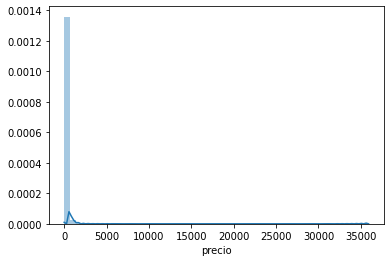

In [111]:
# Graficamos la distribución del precio
sns.distplot(precio_sucursal_producto['precio'])

Veamos los productos con precios mayores a 30000.

In [112]:
precio_sucursal_producto[precio_sucursal_producto.precio>30000]

,precio,producto_id,sucursal_id,fecha,marca,nombre,presentacion,categoria1,categoria2,categoria3,comercioId,banderaId,banderaDescripcion,comercioRazonSocial,provincia,localidad,direccion,lat,lng,sucursalNombre,sucursalTipo,nom_provincia,region,cantidad,unidad,nombre_sin_um
22045,30528.00,3049614158322,12-1-185,20200412,LA GRANDE DAME,Champagne en Estuche La Grande Dame Rose 750 Cc,750.0 cc,NaN,NaN,NaN,12.0,1.0,COTO CICSA,Coto Centro Integral de Comercialización S.A.,AR-Q,Neuquen,Dr Ramon 382,-38.942150,-68.064469,NEUQUEN,Hipermercado,Neuquén,Patagonia,750.0,cc,Champagne en Estuche La Grande Dame Rose
22336,32860.00,3185370611746,12-1-185,20200412,DOM PERIGNON,Champagne Rose Estuche Dom Perignon 750 Cc 1 Un,750.0 cc,NaN,NaN,NaN,12.0,1.0,COTO CICSA,Coto Centro Integral de Comercialización S.A.,AR-Q,Neuquen,Dr Ramon 382,-38.942150,-68.064469,NEUQUEN,Hipermercado,Neuquén,Patagonia,750.0,cc,Champagne Rose Estuche Dom Perignon 1 Un
22337,31000.00,3185370611746,12-1-209,20200412,DOM PERIGNON,Champagne Rose Estuche Dom Perignon 750 Cc 1 Un,750.0 cc,NaN,NaN,NaN,12.0,1.0,COTO CICSA,Coto Centro Integral de Comercialización S.A.,AR-M,Mendoza,Av. Peru 2760,-32.871591,-68.843574,MENDOZA,Hipermercado,Mendoza,Cuyo,750.0,cc,Champagne Rose Estuche Dom Perignon 1 Un
30971,34417.15,5000299284926,12-1-185,20200412,CHIVAS REGAL,Whisky 25 Años Chivas Regal 700 Ml,700.0 ml,NaN,NaN,NaN,12.0,1.0,COTO CICSA,Coto Centro Integral de Comercialización S.A.,AR-Q,Neuquen,Dr Ramon 382,-38.942150,-68.064469,NEUQUEN,Hipermercado,Neuquén,Patagonia,700.0,ml,Whisky 25 Años Chivas Regal
30972,32469.00,5000299284926,12-1-209,20200412,CHIVAS REGAL,Whisky 25 Años Chivas Regal 700 Ml,700.0 ml,NaN,NaN,NaN,12.0,1.0,COTO CICSA,Coto Centro Integral de Comercialización S.A.,AR-M,Mendoza,Av. Peru 2760,-32.871591,-68.843574,MENDOZA,Hipermercado,Mendoza,Cuyo,700.0,ml,Whisky 25 Años Chivas Regal
493404,30528.00,3049614158322,12-1-185,20200419,LA GRANDE DAME,Champagne en Estuche La Grande Dame Rose 750 Cc,750.0 cc,NaN,NaN,NaN,12.0,1.0,COTO CICSA,Coto Centro Integral de Comercialización S.A.,AR-Q,Neuquen,Dr Ramon 382,-38.942150,-68.064469,NEUQUEN,Hipermercado,Neuquén,Patagonia,750.0,cc,Champagne en Estuche La Grande Dame Rose
493667,32860.00,3185370611746,12-1-185,20200419,DOM PERIGNON,Champagne Rose Estuche Dom Perignon 750 Cc 1 Un,750.0 cc,NaN,NaN,NaN,12.0,1.0,COTO CICSA,Coto Centro Integral de Comercialización S.A.,AR-Q,Neuquen,Dr Ramon 382,-38.942150,-68.064469,NEUQUEN,Hipermercado,Neuquén,Patagonia,750.0,cc,Champagne Rose Estuche Dom Perignon 1 Un
493668,31000.00,3185370611746,12-1-209,20200419,DOM PERIGNON,Champagne Rose Estuche Dom Perignon 750 Cc 1 Un,750.0 cc,NaN,NaN,NaN,12.0,1.0,COTO CICSA,Coto Centro Integral de Comercialización S.A.,AR-M,Mendoza,Av. Peru 2760,-32.871591,-68.843574,MENDOZA,Hipermercado,Mendoza,Cuyo,750.0,cc,Champagne Rose Estuche Dom Perignon 1 Un
502123,34417.15,5000299284926,12-1-185,20200419,CHIVAS REGAL,Whisky 25 Años Chivas Regal 700 Ml,700.0 ml,NaN,NaN,NaN,12.0,1.0,COTO CICSA,Coto Centro Integral de Comercialización S.A.,AR-Q,Neuquen,Dr Ramon 382,-38.942150,-68.064469,NEUQUEN,Hipermercado,Neuquén,Patagonia,700.0,ml,Whisky 25 Años Chivas Regal
952754,30528.00,3049614158322,12-1-185,20200426,LA GRANDE DAME,Champagne en Estuche La Grande Dame Rose 750 Cc,750.0 cc,NaN,NaN,NaN,12.0,1.0,COTO CICSA,Coto Centro Integral de Comercialización S.A.,AR-Q,Neuquen,Dr Ramon 382,-38.942150,-68.064469,NEUQUEN,Hipermercado,Neuquén,Patagonia,750.0,cc,Champagne en Estuche La Grande Dame Rose


Vemos que se trata de bebidas con alcohol.

Por otro lado, analicemos la distribución de precios por región.

In [113]:
# Distribución de precio en región 
fig = px.box(precio_sucursal_producto[precio_sucursal_producto.region=='Centro'], y='precio',x='provincia')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

### Análisis de Categorias de Precios

Cantidad de valores presentes en el dataset:

In [114]:
precio_sucursal_producto[~precio_sucursal_producto.categoria1.isna()].count()['categoria1']

5

Como los valores son demasiados pocos, no podemos hacer ningún tipo de inferencia. Es posible generar algun script automatico que te designe la categoria?

In [115]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [116]:
word_count = {}

def count_word(list_word):
  for item in list_word:
    if item in word_count:
      word_count[item] = word_count.get(item) + 1
    else:
      word_count[item] = 1

precio_sucursal_producto['nombre_sin_um'].apply(word_tokenize).apply(lambda x: count_word(x))

0          None
1          None
2          None
3          None
4          None
           ... 
2222413    None
2222414    None
2222415    None
2222416    None
2222417    None
Name: nombre_sin_um, Length: 2214788, dtype: object

In [117]:
sorted(word_count.items(), key=lambda x: x[1], reverse=True)

[('de', 442834),
 ('en', 267017),
 ('con', 200306),
 ('para', 119833),
 ('La', 111847),
 ('Vino', 111096),
 ('y', 93656),
 ('Crema', 88852),
 ('Galletitas', 83784),
 ('Leche', 80166),
 ('Chocolate', 80091),
 ('Desodorante', 74831),
 ('Un', 72316),
 ('Jabon', 72287),
 ('Liquido', 70448),
 ('Shampoo', 70113),
 ('Polvo', 69216),
 ('sin', 68683),
 ('Tinto', 66010),
 ('Limpiador', 57264),
 ('Queso', 54996),
 ('Vainilla', 54575),
 ('Acondicionador', 54517),
 ('Doy', 52358),
 ('Dulce', 47829),
 ('Aerosol', 47148),
 ('Jugo', 46629),
 ('Agua', 45206),
 ('Light', 42422),
 ('Yogur', 40619),
 ('Naranja', 40376),
 ('Blanco', 39754),
 ('Fideos', 39255),
 ('Frutilla', 37059),
 ('3', 35611),
 ('Gas', 34215),
 ('Limon', 33534),
 ('Dental', 32900),
 ('Arroz', 32625),
 ('Ropa', 30971),
 ('Mate', 30688),
 ('Saquitos', 30658),
 ('Malbec', 30211),
 ('Cerveza', 29570),
 ('Cafe', 28501),
 ('Saborizada', 27817),
 ('Lata', 27479),
 ('Extra', 26814),
 ('Clasico', 26645),
 ('Arcor', 26357),
 ('Glade', 26261),
 ('